In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import datetime as dt

2021-09-27 08:11:49.179090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv("../input/apple-share-price/apple_share_price.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")
df.head()

,Date,Open,High,Low,Close,Volume
1663,2011-01-03,46.52,47.18,46.41,47.08,111280407
1662,2011-01-04,47.49,47.50,46.88,47.33,77337001
1661,2011-01-05,47.08,47.76,47.07,47.71,63879193
1660,2011-01-06,47.82,47.89,47.56,47.68,75106626
1659,2011-01-07,47.71,48.05,47.41,48.02,77982212


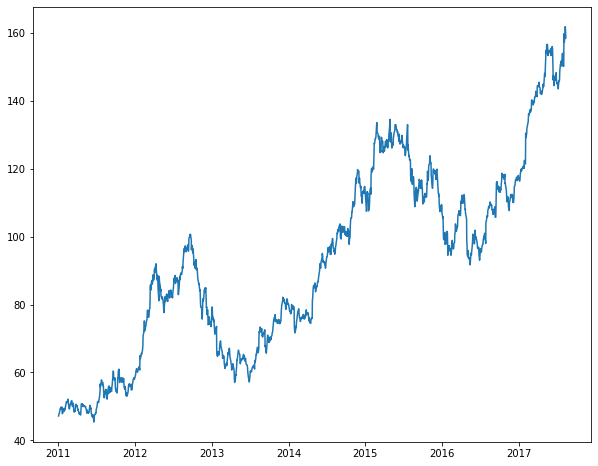

In [4]:
plt.figure(figsize = (10,8))
plt.plot(df.Date,df.High)

In [5]:
new_df = df.drop(columns = "Date")
new_df.head()

,Open,High,Low,Close,Volume
1663,46.52,47.18,46.41,47.08,111280407
1662,47.49,47.50,46.88,47.33,77337001
1661,47.08,47.76,47.07,47.71,63879193
1660,47.82,47.89,47.56,47.68,75106626
1659,47.71,48.05,47.41,48.02,77982212


In [55]:
#split_data
split = 0.2
split_index = int((1 - split) * len(new_df))

X_train = np.array(new_df[:split_index])
date_train = df.iloc[:split_index,0]
X_test = np.array(new_df[split_index:])
date_test = df.iloc[split_index:,0]


print(f"shape of training dataset: {X_train.shape}")

print(f"shape of validation_dataset: {X_test.shape}")


shape of training dataset: (1331, 5)
shape of validation_dataset: (333, 5)


In [40]:
#scaling
scaler= StandardScaler()
S_train = scaler.fit_transform(X_train)
S_test = scaler.transform(X_test)

In [29]:
def windowing(series , window_size ,  batch_size , shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1 , shift = 1 , drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1] , w[-1:,1]))
    return ds.batch(batch_size)


In [41]:
window_size = 20
batch_size = 32
shuffle_buffer= 1000
dataset = windowing(S_train,window_size ,batch_size, shuffle_buffer)

In [43]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=[None,5], return_sequences = True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('linear'))
model.compile(loss = "mse" , optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
            metrics = ["mae"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 32)          4864      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(dataset , epochs=100 , verbose = 0 )

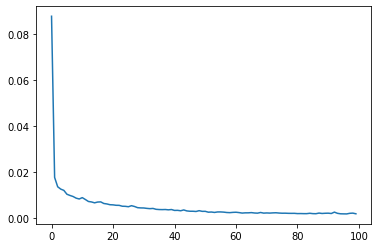

In [45]:
history.history.keys()
plt.plot(history.history["loss"])


Text(0.5, 1.0, 'Training data')

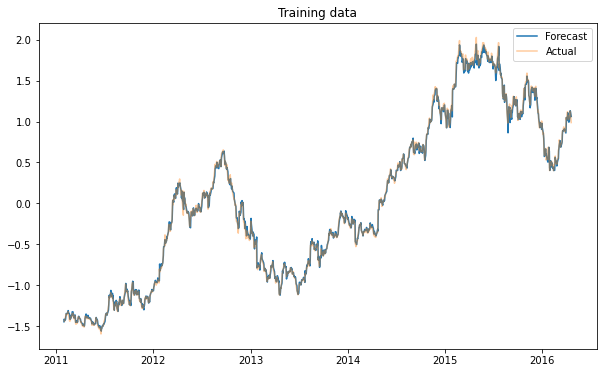

In [65]:
forecast = []
actual = []
for time in range(len(S_train) - window_size):
    y = model.predict(S_train[time:time + window_size][np.newaxis])
    forecast.append(y[0])
    
i = 0   
for value in S_train:
    if i <= window_size:
        i += 1
        continue
    else:
        actual.append(value[1])



plt.figure(figsize=(10, 6))

plt.plot(date_train[20:],forecast, label = "Forecast")
plt.plot(date_train[21:],actual, alpha = 0.4 , label="Actual")
plt.legend()
plt.title("Training data")

Text(0.5, 1.0, 'Test data')

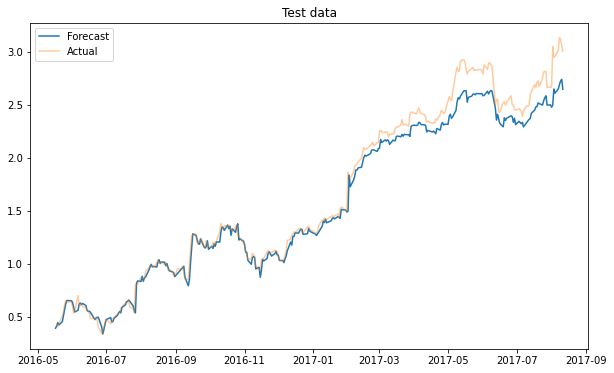

In [63]:
forecast = []
actual = []
for time in range(len(S_test) - window_size):
    y = model.predict(S_test[time:time + window_size][np.newaxis])
    forecast.append(y[0])
i = 0   
for value in S_test:
    if i <= window_size:
        i += 1
        continue
    else:
        actual.append(value[1])



plt.figure(figsize=(10, 6))

plt.plot(date_test[20:],forecast, label = "Forecast")
plt.plot(date_test[21:],actual, alpha = 0.4 , label="Actual")
plt.legend()
plt.title("Test data")

In [61]:
len(actual)

302